In [28]:
from statistics import mode
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt


epsilons = [0,.05,.1,.15,.2,.25,.3,.35,.4,.45,.5]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor()
            ])),
        batch_size=1, shuffle=True)
#test_img_loader = torch.utils.data.DataLoader()


print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

model = Net().to(device)
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
model.eval()

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def pgd_attack(model, images, target, alpha, eps=0.3, iters=10) :
    images = images.to(device)
    target = target.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, target).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

def test( model, device, test_loader, epsilon ):
    correct = 0
    adv_examples = []
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        
        init_pred = output.max(1, keepdim=True)[1] 
        if init_pred.item() != target.item():
            continue

        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        #perturbed_data = pgd_attack(model, data, target,alpha=epsilon)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1] 
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print("EPS = {} \tCorrect/Total : {}/{}\tAccuracy = {}".format(epsilon,correct,len(test_loader),final_acc))

    return final_acc, adv_examples

accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

CUDA Available:  True
EPS = 0 	Correct/Total : 9810/10000	Accuracy = 0.981
EPS = 0.05 	Correct/Total : 9426/10000	Accuracy = 0.9426
EPS = 0.1 	Correct/Total : 8510/10000	Accuracy = 0.851
EPS = 0.15 	Correct/Total : 6826/10000	Accuracy = 0.6826
EPS = 0.2 	Correct/Total : 4301/10000	Accuracy = 0.4301
EPS = 0.25 	Correct/Total : 2082/10000	Accuracy = 0.2082
EPS = 0.3 	Correct/Total : 869/10000	Accuracy = 0.0869
EPS = 0.35 	Correct/Total : 352/10000	Accuracy = 0.0352
EPS = 0.4 	Correct/Total : 167/10000	Accuracy = 0.0167
EPS = 0.45 	Correct/Total : 85/10000	Accuracy = 0.0085
EPS = 0.5 	Correct/Total : 63/10000	Accuracy = 0.0063


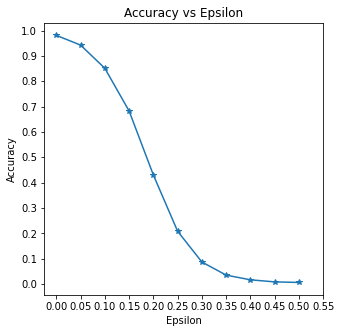

In [32]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .6, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

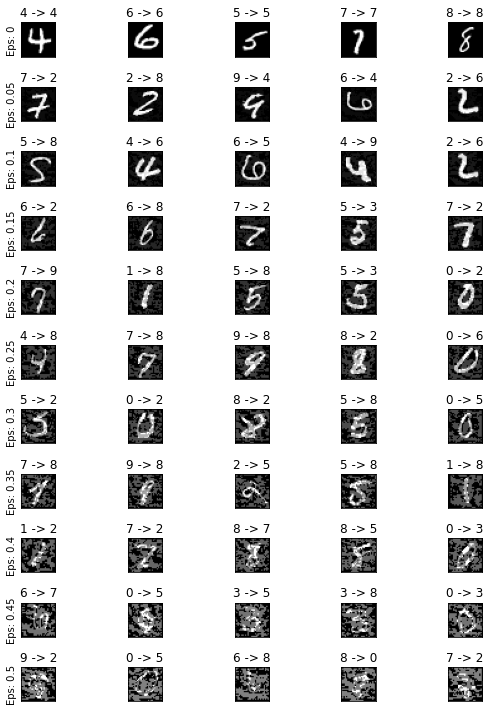

In [33]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=10)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()